### Galaxy-Flux correlation in bins of cz

/tmp/ipykernel_11174/3135835816.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


/tmp/ipykernel_11174/3135835816.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


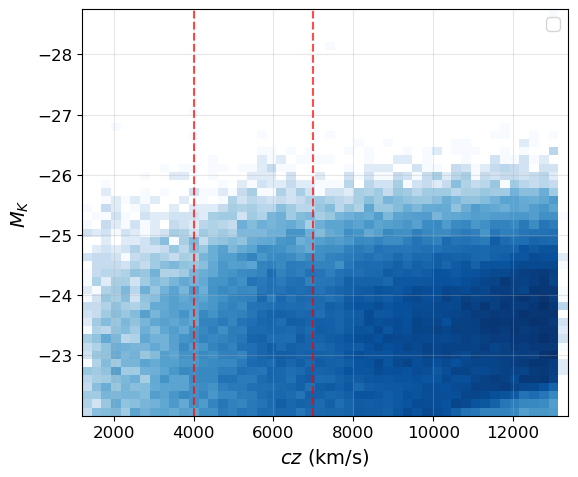

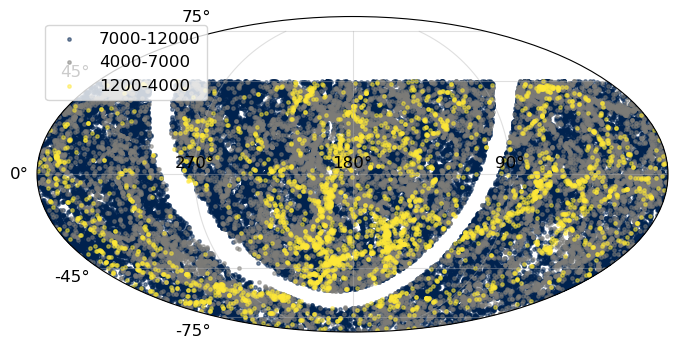

Processing slice: 1200 4000
Processing slice: 4000 7000
Processing slice: 7000 12000


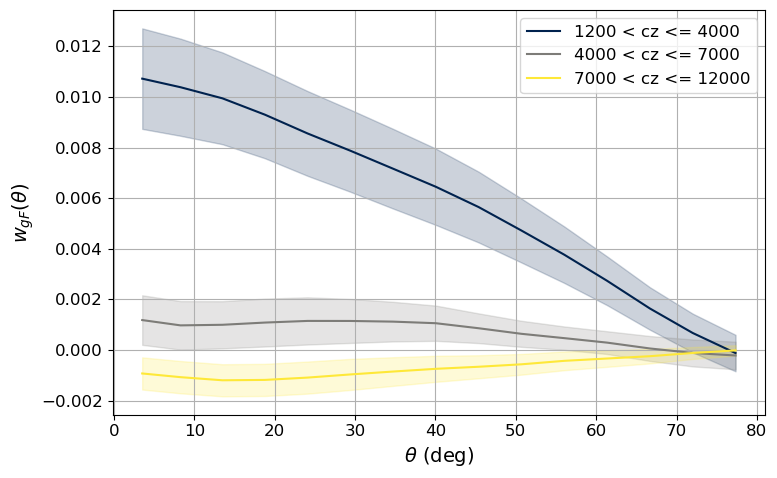

In [13]:
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df[df["Dec"] < 45.]

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 50,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)
gxs = gxs[gxs['M_K'] < -22.0]  # Apply absolute magnitude cut

# Validate gxs catalog
# required_columns = ['RA', 'Dec', 'cz']
# for col in required_columns:
#     if col not in gxs.colnames:
#         raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=10)

"""
VISUALIZE GALAXY DISTRIBUTION BEFORE CORRELATIONS
"""
cz_slices = [(1200, 4000), (4000, 7000), (7000, 12000)]
colors = plt.cm.cividis(np.linspace(0, 1, len(cz_slices)))  # consistent color palette

# --- 1. Absolute magnitude vs cz ---
fig, ax = plt.subplots(figsize=(6, 5))
#for i, (cz_min, cz_max) in enumerate(cz_slices):
#    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
ax.hist2d(gxs['cz'], gxs['M_K'], bins=[50, 50], cmap='Blues', norm=plt.matplotlib.colors.LogNorm())
ax.axvline(4000, color='red', linestyle='--', alpha=0.7)
ax.axvline(7000, color='red', linestyle='--', alpha=0.7)


ax.set_xlabel(r'$cz$ (km/s)')
ax.set_ylabel(r'$M_K$')
ax.invert_yaxis()  # brighter galaxies at top
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. Mollweide skymap ---
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='mollweide')

for i, (cz_min, cz_max) in enumerate(cz_slices[::-1]):
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
    ra_rad = np.radians(gxs_slice['RA'])
    dec_rad = np.radians(gxs_slice['Dec'])
    # Convert RA to [-π, π] for proper Mollweide projection
    ra_rad = -ra_rad+np.pi  # flip RA for astronomy convention
    ax.scatter(ra_rad, dec_rad, s=6, alpha=0.5, color=colors[i], label=f'{cz_min}-{cz_max}')

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])
#ax.set_xlabel('Right Ascension')

#ax.set_ylabel('Declination')
ax.legend()#(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(cz_slices))
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
# cz_slices = [(1200, 4000), (4000, 7000), (7000, 12000)]  # cz slices in km/s
# colors = plt.cm.cividis(np.linspace(0, 1, len(cz_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

for i, (cz_min, cz_max) in enumerate(cz_slices):

    print('Processing slice:', cz_min, cz_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg', npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value

    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{cz_min} < cz <= {cz_max}')

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()